## The style transfer pipeline

As any common neural network, the objective here is to design our pipeline to minimize the Total loss mentioned above. We are going to use Keras to build our network. 

The requirements are as follows :

In [1]:
import keras
import  tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

print("Tensorflow version >= " , tf.__version__)
print("Keras version >= " , keras.__version__)
print("Numpy version >= " , np.__version__)
print("Matplotlib version >= " , matplotlib.__version__)

Using TensorFlow backend.


Tensorflow version >=  1.13.1
Keras version >=  2.2.4
Numpy version >=  1.16.3
Matplotlib version >=  3.0.3


In [0]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import os
from keras.applications import vgg19
from keras import backend as K
import cv2

In [0]:
def mkdir(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [0]:
def get_ImgfrmURL(url):
  from skimage import io
  img = io.imread(url)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  return img

### USER INPUTS

In [0]:
content_img_url = 'https://diy.sndimg.com/content/dam/images/diy/fullset/2009/6/2/0/hgPG-2057168-Upwardly_Mobile_morning_glory.jpg.rend.hgtvcom.616.411.suffix/1420674126446.jpeg'
style_img_url = 'https://www.artistsandillustrators.co.uk/uploads/tinymce/images/new_config_1.jpg'

############## Different Loss weight components
img_nrows = 300 #Height of generated image. This will be used to calculate the width of generated images based on Aspect Ratio of original image
content_weight = 0.5 #alpha
style_weight = 0.8 #beta
total_variation_weight = 0.8  #gamma
iterations = 60 #Number of iteration to optimise the Total-Loss

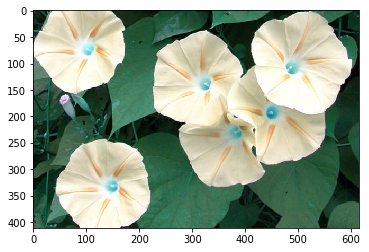

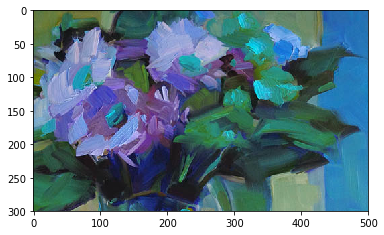

In [6]:
url_content_img = get_ImgfrmURL(content_img_url)
plt.imshow(url_content_img)
plt.show()
url_style_img = get_ImgfrmURL(style_img_url)
plt.imshow(url_style_img)
plt.show()

In [0]:
############## Content and Style Image paths 
content_image_path = 'images/content_imgs/'
style_image_path = 'images/style_imgs/'
out_folder = 'ST_results'
mkdir(out_folder)
mkdir(content_image_path)
mkdir(style_image_path)

content_image_path = content_image_path + '/content1.jpg'
style_image_path = style_image_path + '/style1.jpg'

cv2.imwrite(content_image_path , url_content_img)
cv2.imwrite(style_image_path , url_style_img)


############## Generated (output) Image Dimensions
width, height = load_img(content_image_path).size
img_ncols = int(width * img_nrows / height)#Width of generated image
generated_imsize = (img_nrows , img_ncols)

## Preprocessing and Deprocessing of the images to suit VGG-19 requirements

In [0]:
def prepare_img_array(img_path , target_size = (224,224)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

def preprocess_image(img):
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(img , img_nrows , img_ncols):
    if K.image_data_format() == 'channels_first':
        img = img.reshape((3, img_nrows, img_ncols))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_nrows, img_ncols, 3))
    print(img.shape)
    # Remove zero-center by mean pixel based on VGG standard values
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [9]:
# get tensor representations of our images
content_image = prepare_img_array(content_image_path , generated_imsize)
style_image = prepare_img_array(style_image_path , generated_imsize)

content_image_pp = preprocess_image(content_image)
style_image_pp = preprocess_image(style_image)

content_image_dp = deprocess_image(content_image_pp, img_nrows , img_ncols)
style_image_dp = deprocess_image(style_image_pp, img_nrows , img_ncols)

orig_image = content_image

(300, 449, 3)
(300, 449, 3)


## Visualisations

Orig Image


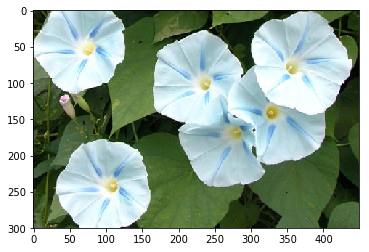

Preprocessed Image


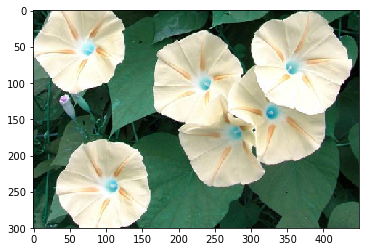

Deprocessed Image


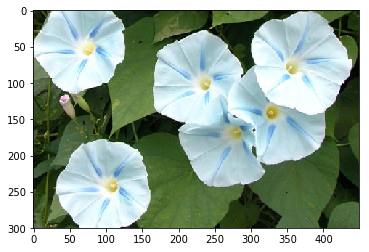

In [10]:
print("Orig Image")
plt.imshow(orig_image[0].astype('uint8'))
plt.show()
print("Preprocessed Image")
plt.imshow(content_image_pp[0].astype('uint8'))
plt.show()
print("Deprocessed Image")
plt.imshow(content_image_dp.astype('uint8'))
plt.show()

## Create a composite tensor to hold Content Image , Style Image and Generated (Combined) Image

In [11]:
# Convert images from array to tensor
content_image_pp = K.variable(content_image_pp)
style_image_pp = K.variable(style_image_pp)

# Preparing the tensor for holding the generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([content_image_pp,
                              style_image_pp,
                              combination_image], axis=0)

Instructions for updating:
Colocations handled automatically by placer.


## VGG-19 Model 

Here we load the pretrained VGG-19 model (inbuilt in Keras) and print the summary

In [12]:
def load_VGG19(input_tensor , include_top=False):
    """
     include_top: whether to include the 3 fully-connected layers at the top of the network.
     weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet)
     input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model
     
     More options at : 
     https://keras.io/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19
    """
    model = vgg19.VGG19(input_tensor=input_tensor , include_top=include_top,weights='imagenet') # input_tensor=input_tensor 
    return model 

include_top = False
vgg19_model = load_VGG19(input_tensor,include_top)
vgg19_model.summary()

80142336/80134624 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

In [13]:
# Make a dictionary of layers of the loaded VGG-19 model with the layer names as the keys for further use 
outputs_dict = dict([(layer.name, layer.output) for layer in vgg19_model.layers])
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 300, 449, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 300, 449, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 150, 224, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 150, 224, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 150, 224, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 75, 112, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 37, 56, 256) dtype=float32>,
 'bloc

## Loss Functions
### Content Loss (L<sub>content</sub>)

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

### Gram Matrix and Style Loss (L<sub>style</sub>)

In [0]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

### Total Variation Loss (L<sub>tv</sub>)

In [0]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Features Extraction from VGG-19 and initialisation of loss and gradients

In [17]:
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
    
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)

## Evaluation function to calculate the gradient and losses  

In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Optimising the the losses and generating the output 

The Evaluator() class defined above provides methods to access loss and gradients.Now we have a computation graph ready . How do we optimize it ?
There are many optimisation techniques ranging from simplest (like gradient_descent) to most sophisticated ones (like ADAM) 

In this case, for ease of implementation we can use limited memory BFGS , from scipy.optimize package. It helps us optimise our loss functions easily without breaking our head on the implementation part. Please have a look at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html#scipy-optimize-fmin-l-bfgs-b for more details.

In [19]:
x = preprocess_image(content_image)
generated_images = []
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=30)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy() , img_nrows , img_ncols)
    fname = out_folder + '/out_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    generated_images.append(img)

Start of iteration 0
Current loss value: 2002038500.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_0.png
Iteration 0 completed in 12s
Start of iteration 1
Current loss value: 1476814500.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 1242608500.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_2.png
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 1098519000.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_3.png
Iteration 3 completed in 7s
Start of iteration 4
Current loss value: 1013093600.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_4.png
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 938132860.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_5.png
Iteration 5 completed in 7s
Start of iteration 6
Current loss value: 881534340.0
(300, 449, 3)
Image saved as ST_results/out_at_iteration_6.png
Iteration 6 co

## Visualisations
Have a look at the changes in smoothness of the generated image as we move through the iterations

Content Image


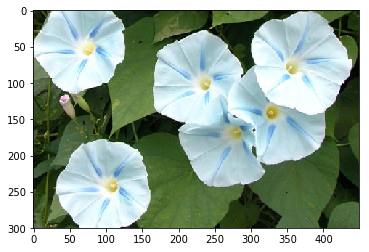



Style Image


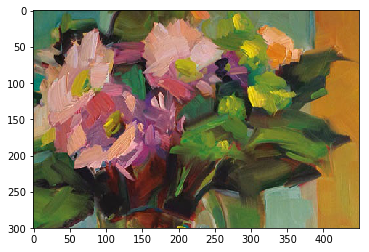



================= Iteration :  0


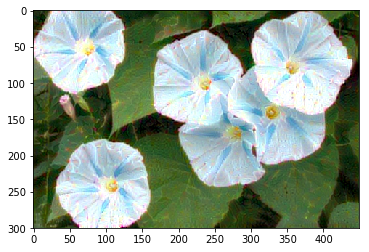



================= Iteration :  2


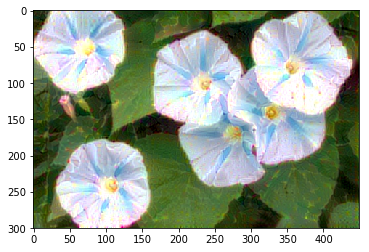



================= Iteration :  4


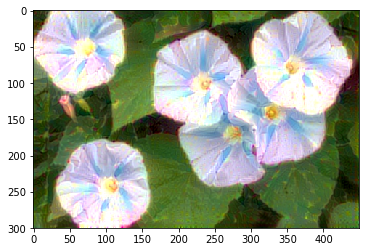



================= Iteration :  6


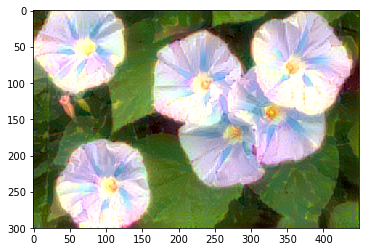



================= Iteration :  8


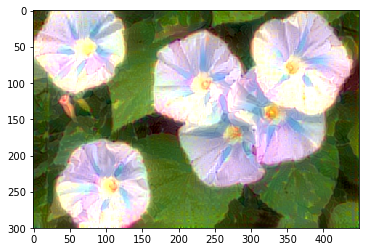



================= Iteration :  10


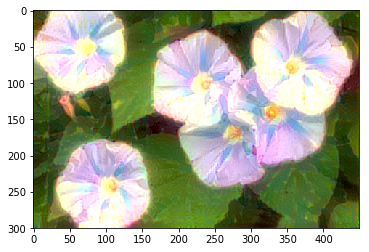



================= Iteration :  12


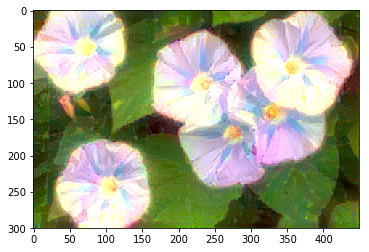



================= Iteration :  14


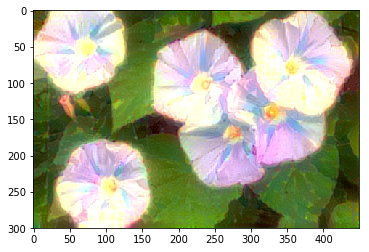



================= Iteration :  16


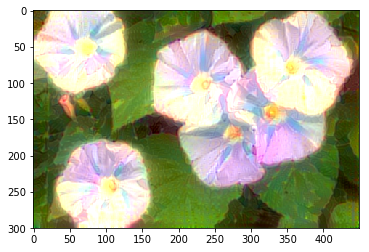



================= Iteration :  18


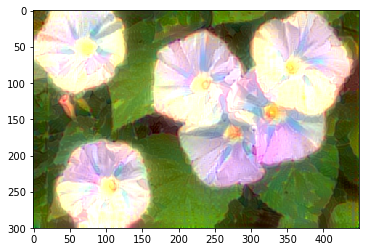



================= Iteration :  20


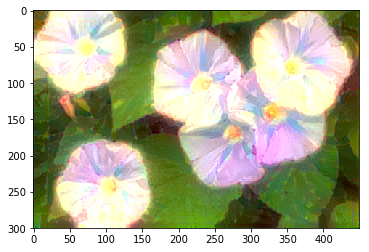



================= Iteration :  22


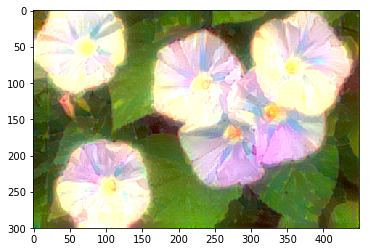



================= Iteration :  24


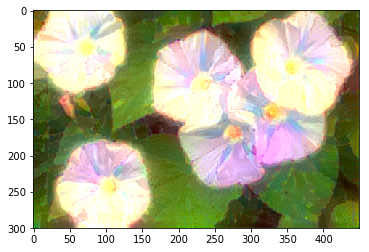



================= Iteration :  26


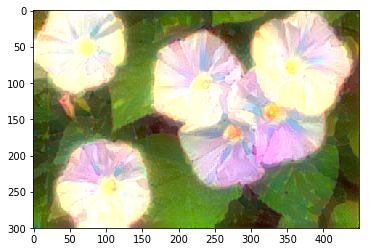



================= Iteration :  28


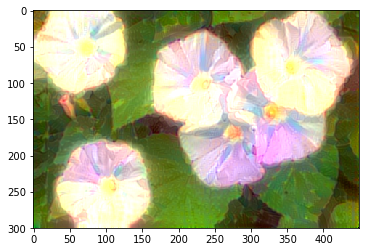



================= Iteration :  30


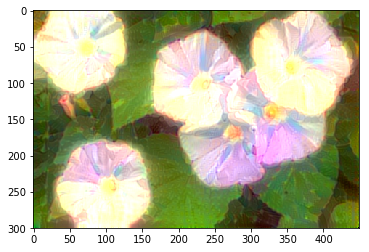



================= Iteration :  32


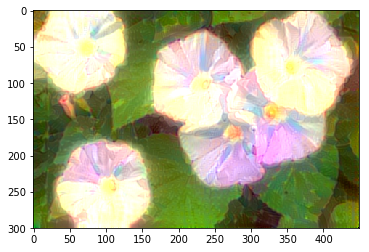



================= Iteration :  34


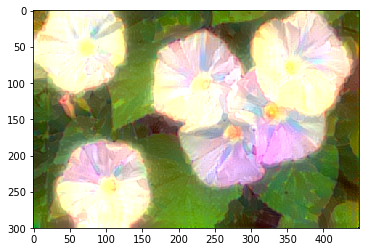



================= Iteration :  36


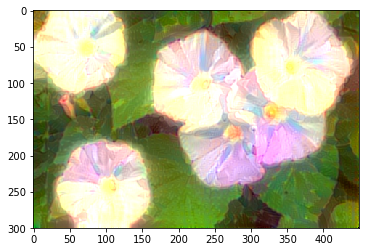



================= Iteration :  38


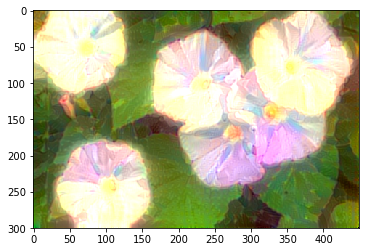



================= Iteration :  40


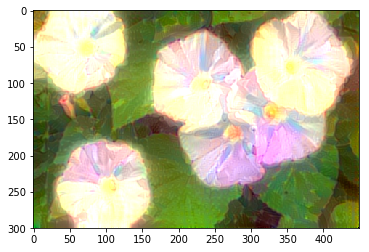



================= Iteration :  42


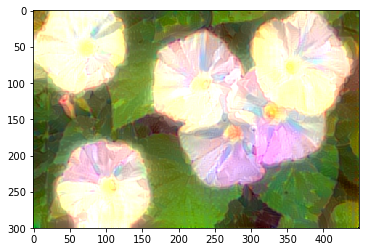



================= Iteration :  44


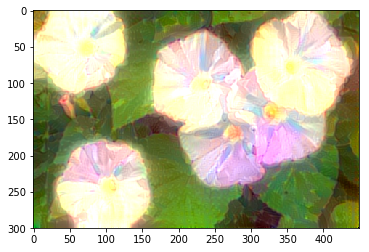



================= Iteration :  46


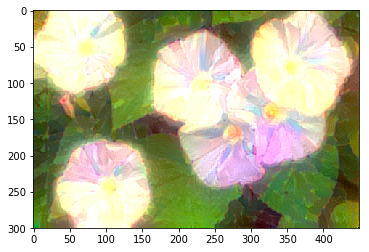



================= Iteration :  48


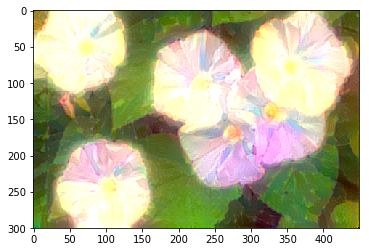



================= Iteration :  50


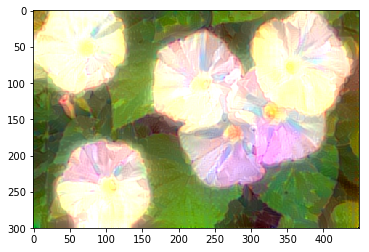



================= Iteration :  52


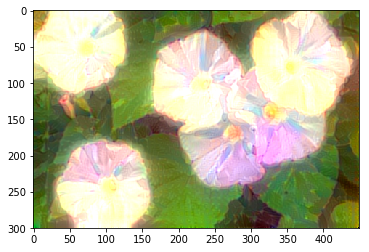



================= Iteration :  54


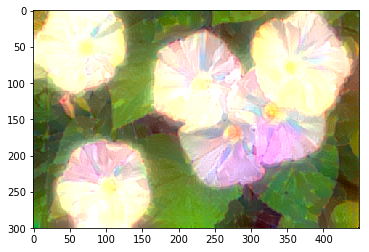



================= Iteration :  56


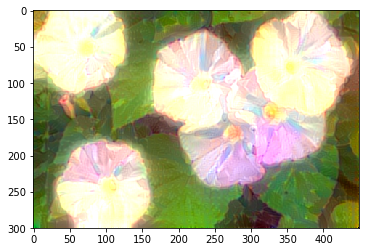



================= Iteration :  58


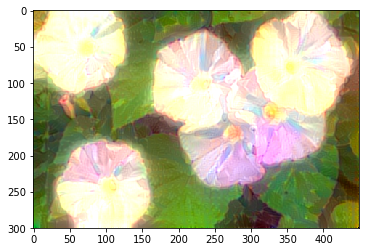

In [20]:
print("Content Image")
plt.imshow(content_image_dp.astype('uint8'))
plt.show()

print("\n\nStyle Image")
plt.imshow(style_image_dp.astype('uint8'))
plt.show()

for i,g in enumerate(generated_images):
    if i%2 == 0 :
        print("\n\n================= Iteration : ",i)
        plt.imshow(g)
        plt.show()